| **Aspect** | **Basic Neural Network (NN)** | **RNN (Recurrent Neural Network)** | **LSTM (Long Short-Term Memory)** |
|------------|-------------------------------|------------------------------------|-----------------------------------|
| **Core Concept** | - Processes independent data through layers (input, hidden, output) in one pass. <br> - No concept of time or sequence; each input is processed separately. <br> - Uses feedforward architecture (data flows one way). <br> - Designed for static tasks like image classification or regression. | - Extends NN to handle sequential data with a time axis (x-axis = time steps). <br> - Uses a loop to process sequences, sharing information across time steps. <br> - Designed for tasks like predicting the next word in a sentence. <br> - Captures patterns in ordered data using a time-based structure. | - A specialized RNN that improves memory for long sequences. <br> - Uses gates to control information flow, retaining key data over time. <br> - Designed for tasks requiring long-term dependencies, like speech recognition. <br> - Enhances RNNs by better handling extended sequences. |
| **Hidden State** | - No hidden state; hidden layers process input directly to output. <br> - No memory of previous inputs; each data point is independent. <br> - Output depends only on current input and weights. <br> - Example: Predicts a label without considering past data. | - Maintains a **hidden state** as memory, updated at each time step. <br> - Hidden state passes information from one time step to the next. <br> - Captures sequential patterns but focuses more on recent time steps. <br> - Limited by memory fading over long sequences. | - Uses a **hidden state** and a **cell state** for enhanced memory. <br> - Cell state carries long-term information across many time steps. <br> - Gates decide what to keep or discard, preserving early data. <br> - Remembers important information from earlier in the sequence. |
| **Vanishing Gradient Problem** | - Gradients can vanish in deep NNs, making training harder for many layers. <br> - No time axis, so vanishing gradients are less tied to sequences. <br> - Backpropagation adjusts weights based on current input only. <br> - Less problematic for shallow networks or non-sequential tasks. | - Suffers from **vanishing gradients** during backpropagation over time. <br> - Gradients shrink for earlier time steps, making it hard to learn long-term patterns. <br> - Recent time steps dominate, causing memory loss of early data. <br> - Limits ability to capture long sequences effectively. | - Addresses vanishing gradients with **gates** (forget, input, output). <br> - Forget gate discards irrelevant data, preserving gradients for early steps. <br> - Input gate adds new information; output gate controls what to pass on. <br> - Enables learning long-term dependencies without gradient loss. |
| **Time Axis** | - No time axis; processes data as a single instance. <br> - Each input is independent, with no order or sequence. <br> - Layers operate simultaneously, not sequentially. <br> - Example: Classifies an image without considering prior images. | - Treats x-axis as time, processing data in ordered steps. <br> - Each time step processes one element of the sequence (e.g., a word). <br> - Hidden state connects time steps, creating a temporal flow. <br> - Suited for ordered data like text or time series. | - Also uses x-axis as time, like RNN, but with better control. <br> - Gates manage information flow across time steps. <br> - Cell state maintains long-term context, balancing recent and early data. <br> - Ideal for tasks needing memory of distant time steps. |
| **Relation to NN** | - Basic building block: neurons in layers transform inputs to outputs. <br> - Uses weights, biases, and activation functions (e.g., ReLU). <br> - No memory or sequence handling; static processing. <br> - Foundation for all neural network models, including RNNs. | - Builds on NN by adding recurrence (looping mechanism). <br> - Shares weights across time steps, unlike separate layers in NN. <br> - Hidden state acts like a memory layer, linking time steps. <br> - Extends NN for sequential data but inherits gradient issues. | - Extends RNN (and thus NN) with gated architecture. <br> - Uses NN-like layers (weights, activations) in gates for memory control. <br> - Combines recurrence with selective memory to prioritize key data. <br> - Retains NN’s core learning but optimizes for long sequences. |

In [557]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import precision_score, recall_score

import pickle

In [558]:
# Loading the Retailrocket dataset
events_df = pd.read_csv('events.csv')
item_properties_df = pd.read_csv('item_properties_part1.csv')
item_properties_df2 = pd.read_csv('item_properties_part2.csv')
category_tree_df = pd.read_csv('category_tree.csv')

# Data Preprocessing

In [559]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [560]:
events_df.shape

(2756101, 5)

In [561]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [562]:
events_df.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [563]:
events_df.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [564]:
events_df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [565]:
events_df.duplicated().sum()

460

**These insights are critical for preprocessing. The large number of missing transactionid values is expected, as this column is only populated for "transaction" events (a small subset of the data, as most events are "view" or "addtocart").**

In [566]:
# Handle missing values: Filter out rows with missing visitorid or itemid
events_df = events_df.dropna(subset=['visitorid', 'itemid'])

In [567]:
events_df = events_df.drop_duplicates()

In [568]:
events_df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64

In [569]:
events_df = events_df[events_df['event'].isin(['transaction', 'addtocart'])]

In [570]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
17,1433223236124,287857,addtocart,5206,NaN
19,1433221078505,158090,addtocart,10572,NaN
63,1433223543021,1193904,addtocart,255275,NaN
112,1433221941632,599528,addtocart,356475,NaN
130,1433222276276,599528,transaction,356475,4000.0


In [571]:
events_df.event.unique()

array(['addtocart', 'transaction'], dtype=object)

In [572]:
events_df.isnull().sum()

timestamp            0
visitorid            0
event                0
itemid               0
transactionid    68966
dtype: int64

In [573]:
# Sort by visitorid and timestamp to create chronological sequences
events_df = events_df.sort_values(by=['visitorid', 'timestamp'])

In [574]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
1133190,1440914628202,6,addtocart,65273,NaN
138668,1433719818230,150,addtocart,452955,NaN
1361435,1441951932678,155,addtocart,368372,NaN
1357916,1441951937583,155,addtocart,452082,NaN
1368056,1441951967871,155,addtocart,181405,NaN


In [575]:
# Group by visitorid to create sequences of itemids
user_sequences = events_df.groupby('visitorid')['itemid'].apply(list).reset_index()

In [576]:
user_sequences

,visitorid,itemid
0,6,[65273]
1,150,[452955]
2,155,"[368372, 452082, 181405, 41882, 442601, 224623..."
3,172,"[10034, 465522, 465522, 465522, 10034]"
4,177,[6073]
...,...,...
38860,1407398,"[218917, 218917]"
38861,1407430,[190000]
38862,1407437,[389814]
38863,1407512,"[107832, 326819, 54141, 334964, 290723, 398091..."


In [577]:
user_sequences['itemid'][2]

[368372, 452082, 181405, 41882, 442601, 224623, 389974]

In [578]:
# Convert itemids to strings for tokenization (Tokenizer expects strings)
user_sequences['itemid'] = user_sequences['itemid'].apply(lambda x: [str(i) for i in x])

In [579]:
user_sequences

,visitorid,itemid
0,6,[65273]
1,150,[452955]
2,155,"[368372, 452082, 181405, 41882, 442601, 224623..."
3,172,"[10034, 465522, 465522, 465522, 10034]"
4,177,[6073]
...,...,...
38860,1407398,"[218917, 218917]"
38861,1407430,[190000]
38862,1407437,[389814]
38863,1407512,"[107832, 326819, 54141, 334964, 290723, 398091..."


In [580]:
user_sequences['itemid'][2]

['368372', '452082', '181405', '41882', '442601', '224623', '389974']

In [581]:
# Filter sequences with at least 3 items (to ensure meaningful sequences for RNN)
user_sequences = user_sequences[user_sequences['itemid'].apply(len) >= 3]

In [582]:
user_sequences

,visitorid,itemid
2,155,"[368372, 452082, 181405, 41882, 442601, 224623..."
3,172,"[10034, 465522, 465522, 465522, 10034]"
6,264,"[459835, 161949, 459835, 161949]"
14,420,"[187848, 178480, 395273, 304558, 55239, 357779..."
15,539,"[94371, 94371, 94371]"
...,...,...
38839,1406488,"[90230, 96904, 106848, 75035]"
38841,1406518,"[118752, 287449, 308438, 62118]"
38843,1406708,"[342331, 209184, 209184, 209184]"
38855,1407070,"[215596, 215596, 80754, 183756]"


In [583]:
len(user_sequences)

6038

In [584]:
# Calculate sequence lengths
user_sequences['sequence_length'] = user_sequences['itemid'].apply(len)

C:\Users\vrajd\AppData\Local\Temp\ipykernel_22044\3278107608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sequences['sequence_length'] = user_sequences['itemid'].apply(len)


In [585]:
user_sequences

,visitorid,itemid,sequence_length
2,155,"[368372, 452082, 181405, 41882, 442601, 224623...",7
3,172,"[10034, 465522, 465522, 465522, 10034]",5
6,264,"[459835, 161949, 459835, 161949]",4
14,420,"[187848, 178480, 395273, 304558, 55239, 357779...",8
15,539,"[94371, 94371, 94371]",3
...,...,...,...
38839,1406488,"[90230, 96904, 106848, 75035]",4
38841,1406518,"[118752, 287449, 308438, 62118]",4
38843,1406708,"[342331, 209184, 209184, 209184]",4
38855,1407070,"[215596, 215596, 80754, 183756]",4


In [586]:
user_sequences['sequence_length'].describe()

count    6038.000000
mean        8.000497
std        28.398228
min         3.000000
25%         3.000000
50%         4.000000
75%         6.000000
max      1278.000000
Name: sequence_length, dtype: float64

In [587]:
# Detect outliers using IQR
Q1 = user_sequences['sequence_length'].quantile(0.25)
Q3 = user_sequences['sequence_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [588]:
lower_bound

-1.5

In [589]:
upper_bound

10.5

In [590]:
# Identify outliers
outliers = user_sequences[(user_sequences['sequence_length'] < lower_bound) | (user_sequences['sequence_length'] > upper_bound)]

In [591]:
len(outliers)

624

In [592]:
outliers[['visitorid', 'sequence_length']].head()

,visitorid,sequence_length
124,4739,17
161,6170,26
177,6699,12
186,6958,189
250,9145,12


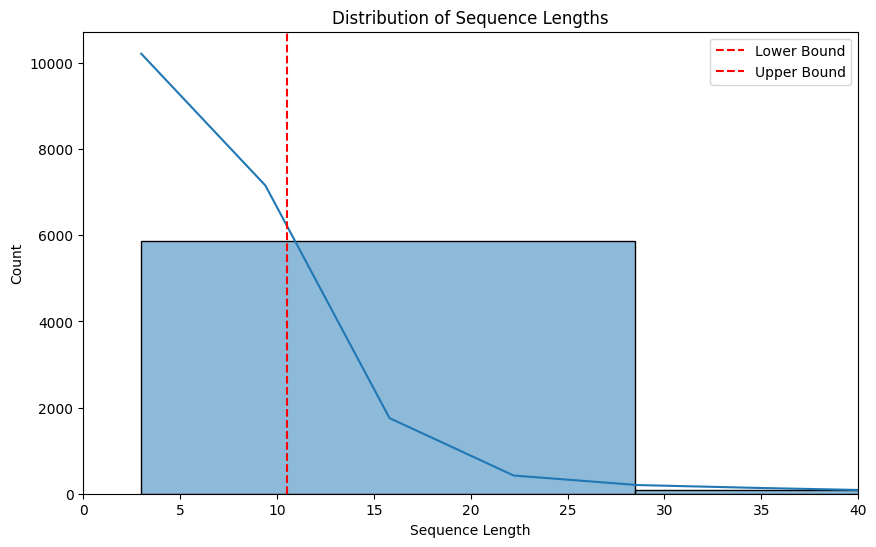

In [593]:
# Visualize sequence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(user_sequences['sequence_length'], bins=50, kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.xlim(0, 40)
plt.legend()
plt.show()

In [594]:
# Tokenize item IDs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(user_sequences['itemid'])
sequences = tokenizer.texts_to_sequences(user_sequences['itemid'])

In [595]:
sequences

[[10487, 10488, 10489, 10490, 10491, 10492, 10493],
 [1798, 168, 168, 168, 1798],
 [582, 5777, 582, 5777],
 [1311, 3798, 387, 1799, 1312, 1010, 1800, 387],
 [467, 467, 467],
 [2502, 2502, 45, 45, 45, 45],
 [99, 99, 99],
 [10494, 5778, 5779, 5779, 5778],
 [388, 388, 388],
 [10495, 5780, 169, 10496],
 [468, 5781, 5781, 468],
 [583, 1801, 583, 1801, 583, 1801, 583, 1313],
 [5782, 5783, 1802, 1802, 5783, 5782],
 [1314, 5784, 5785, 5785, 5784],
 [10497, 66, 66],
 [3799, 2503, 584, 1011, 584, 2503, 1011, 3799],
 [585, 469, 469, 469],
 [1315, 1315, 1315, 1315, 1315],
 [5786, 3800, 5786, 3800],
 [3801, 10498, 3802],
 [1803, 2504, 1803, 2504],
 [5787,
  10499,
  10500,
  10501,
  10502,
  10503,
  10504,
  10505,
  10506,
  10507,
  10508,
  10509,
  10510,
  10511,
  10512,
  10513,
  10514],
 [2505, 760, 1804],
 [761, 761, 761, 761, 5788, 5788],
 [1316, 586, 10515],
 [10516, 5789, 5789],
 [587, 5790, 587, 5790],
 [10517,
  10518,
  10519,
  10520,
  10521,
  10522,
  10523,
  10524,
  10525,


In [624]:
# Pad sequences to a fixed length (maxlen=20 for simplicity, adjustable later)
max_sequence_length = 28
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

In [625]:
padded_sequences

array([[    0,     0,     0, ..., 10491, 10492, 10493],
       [    0,     0,     0, ...,   168,   168,  1798],
       [    0,     0,     0, ...,  5777,   582,  5777],
       ...,
       [    0,     0,     0, ...,  2282,  2282,  2282],
       [    0,     0,     0, ...,  1082,   490,   176],
       [    0,     0,     0, ...,  8748, 16062, 16063]])

In [626]:
padded_sequences[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 10487, 10488, 10489, 10490, 10491, 10492,
       10493])

In [627]:
# Create input-output pairs for RNN (predict next item)
X, y = [], []
for seq in padded_sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

In [628]:
X

[array([0]),
 array([0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [629]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10487,
 10488,
 10489,
 10490,
 10491,
 10492,
 10493,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1798,
 168,
 168,
 168,
 1798,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 582,
 5777,
 582,
 5777,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1311,
 3798,
 387,
 1799,
 1312,
 1010,
 1800,
 387,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 467,
 467,
 467,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2502,
 2502,
 45,
 45,
 45,
 45,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 99,
 99,
 99,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10494,
 5778,
 5779,
 5779,
 5778,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [630]:
# Convert to numpy arrays
X = np.array(pad_sequences(X, maxlen=max_sequence_length, padding='pre'))
y = np.array(y)

In [631]:
X

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 16060, 16061, 10319],
       [    0,     0,     0, ..., 16061, 10319,  8748],
       [    0,     0,     0, ..., 10319,  8748, 16062]])

In [632]:
X.shape

(163026, 28)

In [633]:
len(X)

163026

In [634]:
y

array([    0,     0,     0, ...,  8748, 16062, 16063])

In [635]:
y.shape

(163026,)

In [636]:
# Save tokenizer for later use in deployment
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Model Building

- **lstm_units = 64**:
  - Defines the number of units (or neurons) in each LSTM layer of the RNN model.
  - Controls the model’s capacity to learn patterns in sequential data (e.g., user purchase sequences).
  - 64 units is a moderate size, balancing complexity and computational efficiency, suitable for the Retailrocket dataset’s scale.
  - Larger values (e.g., 128) increase learning capacity but may overfit or slow training; smaller values (e.g., 32) may underfit.
  - Chosen based on common practice in e-commerce recommendation systems.

- **dropout_rate = 0.3**:
  - Specifies the fraction of neurons randomly disabled during training (30% in this case) to prevent overfitting.
  - Helps the model generalize by reducing reliance on specific neurons, improving performance on unseen data.
  - 0.3 is a standard value, balancing regularization and learning.
  - Higher rates (e.g., 0.5) may reduce overfitting more but risk underfitting; lower rates (e.g., 0.1) may allow overfitting.

- **embedding_dim = 50**:
  - Defines the size (number of dimensions) of the dense vector representation for each item ID in the embedding layer.
  - Converts categorical item IDs into numerical vectors that capture relationships (e.g., similar items have closer vectors).
  - 50 dimensions is a moderate size, balancing expressiveness (capturing item features) and computational efficiency for the Retailrocket dataset.
  - Larger values (e.g., 100) capture more complex relationships but increase computation; smaller values (e.g., 20) may miss nuanced patterns.
  - Chosen based on common practice in e-commerce systems.

In [637]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # Number of unique item IDs
max_sequence_length = 28

In [638]:
vocab_size

16064

In [639]:
embedding_dim = 50  # Size of item embeddings

In [640]:
lstm_units = 64  # Number of LSTM units
dropout_rate = 0.5  # Dropout to prevent overfitting

In [641]:
shape=(max_sequence_length,)

In [642]:
shape

(28,)

| **Code Line** | **LSTM/RNN Concept** | **How Implemented in Code** |
|---------------|----------------------|-----------------------------|
| `inputs = Input(shape=(max_sequence_length,))` | **Time Axis**: RNNs/LSTMs process sequential data along a time axis (x-axis = time steps). | Defines input as a sequence of length 10 (`max_sequence_length`), representing time steps (e.g., ordered events), enabling RNN/LSTM to process data sequentially. |
| `embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)` | **Input Preparation for RNN/LSTM**: Converts categorical data into vectors for sequential processing. | Maps each input token (e.g., item ID) to a 50D vector, creating a 3D tensor `(batch_size, 10, 50)` for LSTM to process over time steps. |
| `lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)` | **Hidden State & Memory**: LSTMs use hidden and cell states to retain memory across time steps. **Bidirectional Processing**: Processes sequence forward and backward. | Implements a bidirectional LSTM with 64 units, maintaining hidden/cell states to capture patterns across all 10 time steps, outputting `(batch_size, 10, 128)` with `return_sequences=True` for sequence output. |
| `attention = Attention()([lstm_out, lstm_out])` | **Selective Memory**: LSTMs prioritize important information, enhanced by attention to focus on key time steps. | Applies self-attention to weigh important time steps in the LSTM output, preserving `(batch_size, 10, 128)` shape, enhancing memory for relevant data. |
| `lstm_out = Dropout(dropout_rate)(attention)` | **Prevent Overfitting**: Regularization ensures memory generalizes to new data. | Adds 30% dropout to attention output, preventing over-reliance on specific time steps or patterns in hidden states. |
| `lstm_final = LSTM(lstm_units)(lstm_out)` | **Long-Term Memory**: LSTMs retain important information from earlier time steps via cell state. | Uses a second LSTM (64 units) to summarize the attended sequence into a single vector `(batch_size, 64)`, capturing long-term dependencies for final prediction. |
| `outputs = Dense(vocab_size, activation='softmax')(lstm_final)` | **Prediction from Memory**: Uses LSTM’s memory to predict the next time step’s output. | Converts final LSTM hidden state to probabilities over all possible outputs (vocab_size), predicting the next item in the sequence. |
| `model = Model(inputs=inputs, outputs=outputs)` | **Sequential Model**: Combines RNN/LSTM components into a full model for sequence prediction. | Links all layers (Input → Embedding → Bi-LSTM → Attention → Dropout → LSTM → Dense) to form a complete model for sequential processing and prediction. |
| `model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])` | **Training with Memory**: Optimizes hidden/cell states to learn sequential patterns. | Uses `sparse_categorical_crossentropy` to train the model to predict the next time step, updating hidden/cell states to minimize prediction errors. |

In [643]:
# Build the model
inputs = Input(shape=(max_sequence_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)

lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
attention = Attention()([lstm_out, lstm_out])  # Self-attention on LSTM outputs
lstm_out = Dropout(dropout_rate)(attention)
lstm_final = LSTM(lstm_units)(lstm_out)
outputs = Dense(vocab_size, activation='softmax')(lstm_final)

In [644]:
model = Model(inputs=inputs, outputs=outputs)

In [645]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [646]:
# Model summary
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 28)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_27 (Embedding)      │ (None, 28, 50)            │         803,200 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_12              │ (None, 28, 128)           │          58,880 │ embedding_27[0][0]         │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_6 (Attention)       │ (None, 28, 128)           │               0 │ bidirectional_12[0][0],    │
│                               │                           │                 │ bidirectional_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_22 (Dropout)          │ (None, 28, 128)           │               0 │ attention_6[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_29 (LSTM)                │ (None, 64)                │          49,408 │ dropout_22[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 16064)             │       1,044,160 │ lstm_29[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,955,648 (7.46 MB)

 Trainable params: 1,955,648 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

In [647]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [648]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [649]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[lr_scheduler], verbose=1)

Epoch 1/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 90s 42ms/step - accuracy: 0.7760 - loss: 3.0772 - val_accuracy: 0.7793 - val_loss: 2.2813 - learning_rate: 0.0010
Epoch 2/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.7804 - loss: 2.1357 - val_accuracy: 0.7799 - val_loss: 2.2744 - learning_rate: 0.0010
Epoch 3/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.7809 - loss: 2.0426 - val_accuracy: 0.7801 - val_loss: 2.3279 - learning_rate: 0.0010
Epoch 4/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - accuracy: 0.7819 - loss: 1.9630 - val_accuracy: 0.7803 - val_loss: 2.3786 - learning_rate: 0.0010
Epoch 5/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - accuracy: 0.7812 - loss: 1.8929 - val_accuracy: 0.7804 - val_loss: 2.4245 - learning_rate: 5.0000e-04
Epoch 6/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.7823 - loss: 1.8323 - val_accuracy: 0.7805 - val_loss: 2.4559 - learning_rate: 5.0000e-04
Epoch 7/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step 

In [650]:
# Custom evaluation: Precision@N and Recall@N
def precision_recall_at_n(y_true, y_pred_probs, n=5):
    precision_scores, recall_scores = [], []
    for i in range(len(y_true)):
        top_n = np.argsort(y_pred_probs[i])[-n:]
        true_item = y_true[i]
        precision = 1.0 if true_item in top_n else 0.0
        recall = 1.0 if true_item in top_n else 0.0
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores), np.mean(recall_scores)

# Evaluate on test set
y_pred_probs = model.predict(X_test)
precision, recall = precision_recall_at_n(y_test, y_pred_probs, n=5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
Precision@5: 0.7867
Recall@5: 0.7867


In [651]:
lstm_out = LSTM(lstm_units, return_sequences=False)(embedding)  # Single LSTM, no attention
lstm_out = Dropout(dropout_rate)(lstm_out)
outputs = Dense(vocab_size, activation='softmax')(lstm_out)

In [652]:
model = Model(inputs=inputs, outputs=outputs)

In [653]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [654]:
# Model summary
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_27 (Embedding)             │ (None, 28, 50)              │         803,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 16064)               │       1,044,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,876,800 (7.16 MB)

 Trainable params: 1,876,800 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

In [655]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [656]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [657]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[lr_scheduler], verbose=1)

Epoch 1/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.7720 - loss: 2.9724 - val_accuracy: 0.7796 - val_loss: 2.2309 - learning_rate: 0.0010
Epoch 2/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.7782 - loss: 2.2019 - val_accuracy: 0.7798 - val_loss: 2.2423 - learning_rate: 0.0010
Epoch 3/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7811 - loss: 2.1170 - val_accuracy: 0.7807 - val_loss: 2.2708 - learning_rate: 0.0010
Epoch 4/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7830 - loss: 2.0175 - val_accuracy: 0.7841 - val_loss: 2.2578 - learning_rate: 5.0000e-04
Epoch 5/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7835 - loss: 1.9673 - val_accuracy: 0.7876 - val_loss: 2.2621 - learning_rate: 5.0000e-04
Epoch 6/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7898 - loss: 1.8778 - val_accuracy: 0.7901 - val_loss: 2.2565 - learning_rate: 2.5000e-04
Epoch 7/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/s

In [658]:
# Custom evaluation: Precision@N and Recall@N
def precision_recall_at_n(y_true, y_pred_probs, n=5):
    precision_scores, recall_scores = [], []
    for i in range(len(y_true)):
        top_n = np.argsort(y_pred_probs[i])[-n:]
        true_item = y_true[i]
        precision = 1.0 if true_item in top_n else 0.0
        recall = 1.0 if true_item in top_n else 0.0
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores), np.mean(recall_scores)

# Evaluate on test set
y_pred_probs = model.predict(X_test)
precision, recall = precision_recall_at_n(y_test, y_pred_probs, n=5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Precision@5: 0.8072
Recall@5: 0.8072


In [771]:
# Load datasets
events_df = pd.read_csv('events.csv')
item_properties = pd.concat([pd.read_csv('item_properties_part1.csv'), pd.read_csv('item_properties_part2.csv')])

In [772]:
# Handle missing values and duplicates
events_df = events_df.dropna(subset=['visitorid', 'itemid']).drop_duplicates()

In [773]:
# Include 'view', 'addtocart', 'transaction' events
events_df = events_df[events_df['event'].isin(['addtocart', 'transaction'])]

In [774]:
# Sort by visitorid and timestamp
events_df = events_df.sort_values(by=['visitorid', 'timestamp'])

In [775]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
1133190,1440914628202,6,addtocart,65273,NaN
138668,1433719818230,150,addtocart,452955,NaN
1361435,1441951932678,155,addtocart,368372,NaN
1357916,1441951937583,155,addtocart,452082,NaN
1368056,1441951967871,155,addtocart,181405,NaN


In [776]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [777]:
# Get item categories (property 'categoryid' from item_properties)
item_categories = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']].drop_duplicates()
item_categories['value'] = item_categories['value'].astype(str)

In [778]:
item_categories.head()

,itemid,value
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [779]:
# Merge categories with events
events_df = events_df.merge(item_categories, on='itemid', how='left')
events_df['value'] = events_df['value'].fillna('0')  # Default category for missing values

In [780]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,value
0,1440914628202,6,addtocart,65273,NaN,342
1,1433719818230,150,addtocart,452955,NaN,577
2,1441951932678,155,addtocart,368372,NaN,769
3,1441951937583,155,addtocart,452082,NaN,769
4,1441951967871,155,addtocart,181405,NaN,769


In [781]:
events_df.shape

(97909, 6)

In [783]:
events_df.value.unique()

array(['342', '577', '769', '1219', '196', '1339', '579', '1366', '1421',
       '5', '959', '1613', '491', '1192', '707', '1483', '1220', '1542',
       '1', '535', '120', '618', '1231', '1509', '72', '1213', '1529',
       '1650', '572', '228', '1250', '317', '1325', '1051', '1295',
       '1549', '1646', '1163', '479', '191', '619', '267', '972', '1322',
       '858', '48', '406', '1006', '822', '686', '444', '1393', '1455',
       '1135', '806', '1167', '176', '519', '56', '421', '1186', '1179',
       '1018', '1233', '691', '1147', '1244', '683', '624', '1014',
       '1375', '1188', '523', '914', '1385', '392', '195', '1493', '1625',
       '799', '84', '106', '35', '1298', '1511', '1073', '589', '725',
       '414', '1060', '486', '671', '1003', '944', '531', '1151', '1205',
       '43', '37', '1649', '1665', '65', '0', '844', '417', '1120', '356',
       '928', '175', '525', '1072', '451', '828', '1680', '1037', '720',
       '434', '1240', '678', '1302', '1652', '804', '64', '

In [746]:
# Create sequences of itemids and categories
user_sequences = events_df.groupby('visitorid').agg({'itemid': list, 'value': list}).reset_index()
user_sequences['itemid'] = user_sequences['itemid'].apply(lambda x: [str(i) for i in x])
user_sequences['value'] = user_sequences['value'].apply(lambda x: [str(i) for i in x])

In [747]:
user_sequences

,visitorid,itemid,value
0,6,[65273],[342]
1,150,[452955],[577]
2,155,"[368372, 452082, 181405, 41882, 442601, 224623...","[769, 769, 769, 769, 769, 769, 769]"
3,172,"[10034, 465522, 465522, 465522, 10034]","[1219, 196, 196, 196, 1219]"
4,177,[6073],[1339]
...,...,...,...
38860,1407398,"[218917, 218917]","[48, 48]"
38861,1407430,[190000],[5]
38862,1407437,[389814],[1393]
38863,1407512,"[107832, 107832, 326819, 54141, 334964, 290723...","[1553, 53, 1500, 374, 374, 1196, 1639, 1639, 1..."


In [748]:
# Filter sequences with at least 3 items
user_sequences = user_sequences[user_sequences['itemid'].apply(len) >= 3]

In [749]:
user_sequences

,visitorid,itemid,value
2,155,"[368372, 452082, 181405, 41882, 442601, 224623...","[769, 769, 769, 769, 769, 769, 769]"
3,172,"[10034, 465522, 465522, 465522, 10034]","[1219, 196, 196, 196, 1219]"
5,186,"[49029, 49029, 49029, 49029]","[579, 1366, 579, 1366]"
6,264,"[459835, 161949, 459835, 161949]","[1421, 1421, 1421, 1421]"
14,420,"[187848, 178480, 395273, 304558, 55239, 357779...","[1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
38839,1406488,"[90230, 96904, 106848, 75035]","[1384, 1173, 586, 984]"
38841,1406518,"[118752, 287449, 308438, 62118]","[619, 858, 1650, 987]"
38843,1406708,"[342331, 209184, 209184, 209184]","[224, 224, 224, 224]"
38855,1407070,"[215596, 215596, 80754, 183756]","[48, 48, 411, 411]"


In [750]:
# Tokenize item IDs and categories
item_tokenizer = Tokenizer()
item_tokenizer.fit_on_texts(user_sequences['itemid'])
category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(user_sequences['value'])

In [751]:
item_sequences = item_tokenizer.texts_to_sequences(user_sequences['itemid'])
category_sequences = category_tokenizer.texts_to_sequences(user_sequences['value'])

In [752]:
# Pad sequences
max_sequence_length = 28
item_padded = pad_sequences(item_sequences, maxlen=max_sequence_length, padding='pre')
category_padded = pad_sequences(category_sequences, maxlen=max_sequence_length, padding='pre')

In [753]:
# Create input-output pairs
X_item, X_category, y = [], [], []
for item_seq, cat_seq in zip(item_padded, category_padded):
    for i in range(1, len(item_seq)):
        X_item.append(item_seq[:i])
        X_category.append(cat_seq[:i])
        y.append(item_seq[i])

In [754]:
X_item = np.array(pad_sequences(X_item, maxlen=max_sequence_length, padding='pre'))
X_category = np.array(pad_sequences(X_category, maxlen=max_sequence_length, padding='pre'))
y = np.array(y)

In [755]:
X_item

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 16431, 16432, 10971],
       [    0,     0,     0, ..., 16432, 10971,  9371],
       [    0,     0,     0, ..., 10971,  9371, 16433]])

In [756]:
X_item.shape

(186894, 28)

In [757]:
X_category

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 272, 272,  95],
       [  0,   0,   0, ..., 272,  95, 353],
       [  0,   0,   0, ...,  95, 353, 353]])

In [758]:
X_category.shape

(186894, 28)

In [759]:
y

array([    0,     0,     0, ...,  9371, 16433, 16434])

In [760]:
y.shape

(186894,)

In [761]:
# Model parameters
item_vocab_size = len(item_tokenizer.word_index) + 1
category_vocab_size = len(category_tokenizer.word_index) + 1
embedding_dim = 50
max_sequence_length = 28
lstm_units = 32  # Reduced for efficiency
dropout_rate = 0.5

In [762]:
# Build the model
item_input = Input(shape=(max_sequence_length,), name='item_input')
category_input = Input(shape=(max_sequence_length,), name='category_input')

item_embedding = Embedding(input_dim=item_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(item_input)
category_embedding = Embedding(input_dim=category_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(category_input)

combined_embedding = Concatenate()([item_embedding, category_embedding])
lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=False))(combined_embedding)
lstm_out = Dropout(dropout_rate)(lstm_out)
outputs = Dense(item_vocab_size, activation='softmax')(lstm_out)

model = Model(inputs=[item_input, category_input], outputs=outputs)

C:\Users\vrajd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [763]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [764]:
# Model summary
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item_input (InputLayer)       │ (None, 28)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ category_input (InputLayer)   │ (None, 28)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_32 (Embedding)      │ (None, 28, 50)            │         821,750 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_33 (Embedding)      │ (None, 28, 50)            │          39,200 │ category_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_11 (Concatenate)  │ (None, 28, 100)           │               0 │ embedding_32[0][0],        │
│                               │                           │                 │ embedding_33[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_15              │ (None, 64)                │          34,048 │ concatenate_11[0][0]       │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_27 (Dropout)          │ (None, 64)                │               0 │ bidirectional_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_27 (Dense)              │ (None, 16435)             │       1,068,275 │ dropout_27[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,963,273 (7.49 MB)

 Trainable params: 1,963,273 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [765]:
# Train-test split
X_item_train, X_item_test, X_category_train, X_category_test, y_train, y_test = train_test_split(
    X_item, X_category, y, test_size=0.2, random_state=42)

In [766]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [767]:
# Train the model
history = model.fit(
    [X_item_train, X_category_train], y_train,
    validation_data=([X_item_test, X_category_test], y_test),
    epochs=25, batch_size=64, callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.7744 - loss: 2.9449 - val_accuracy: 0.7842 - val_loss: 2.1798 - learning_rate: 0.0010
Epoch 2/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.7794 - loss: 2.1871 - val_accuracy: 0.7867 - val_loss: 2.1645 - learning_rate: 0.0010
Epoch 3/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.7820 - loss: 2.0783 - val_accuracy: 0.7918 - val_loss: 2.1386 - learning_rate: 0.0010
Epoch 4/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.7871 - loss: 1.9684 - val_accuracy: 0.7990 - val_loss: 2.1132 - learning_rate: 0.0010
Epoch 5/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.7914 - loss: 1.8686 - val_accuracy: 0.8061 - val_loss: 2.0803 - learning_rate: 0.0010
Epoch 6/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 62s 27ms/step - accuracy: 0.7982 - loss: 1.7567 - val_accuracy: 0.8105 - val_loss: 2.0597 - learning_rate: 0.0010
Epoch 7/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accura

In [768]:
# Custom evaluation: Precision@N and Recall@N
def precision_recall_at_n(y_true, y_pred_probs, n=5):
    precision_scores, recall_scores = [], []
    for i in range(len(y_true)):
        top_n = np.argsort(y_pred_probs[i])[-n:]
        true_item = y_true[i]
        precision = 1.0 if true_item in top_n else 0.0
        recall = 1.0 if true_item in top_n else 0.0
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores), np.mean(recall_scores)

# Evaluate on test set
y_pred_probs = model.predict([X_item_test, X_category_test])
precision, recall = precision_recall_at_n(y_test, y_pred_probs, n=5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

1169/1169 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step
Precision@5: 0.8535
Recall@5: 0.8535


In [769]:
# Save the trained model
model.save('rnn_recommender_optimized.h5')

In [770]:
# Save the item tokenizer
with open('item_tokenizer_final.pkl', 'wb') as f:
    pickle.dump(item_tokenizer, f)

# Save the category tokenizer
with open('category_tokenizer_final.pkl', 'wb') as f:
    pickle.dump(category_tokenizer, f)

In [728]:
lstm_out = LSTM(lstm_units, return_sequences=False)(combined_embedding)  # Single LSTM, no attention
lstm_out = Dropout(dropout_rate)(lstm_out)
outputs = Dense(item_vocab_size, activation='softmax')(lstm_out)

model = Model(inputs=[item_input, category_input], outputs=outputs)

In [729]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [730]:
# Model summary
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item_input (InputLayer)       │ (None, 28)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ category_input (InputLayer)   │ (None, 28)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_30 (Embedding)      │ (None, 28, 50)            │         821,750 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_31 (Embedding)      │ (None, 28, 50)            │          39,200 │ category_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_10 (Concatenate)  │ (None, 28, 100)           │               0 │ embedding_30[0][0],        │
│                               │                           │                 │ embedding_31[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_33 (LSTM)                │ (None, 32)                │          17,024 │ concatenate_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_26 (Dropout)          │ (None, 32)                │               0 │ lstm_33[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 16435)             │         542,355 │ dropout_26[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,420,329 (5.42 MB)

 Trainable params: 1,420,329 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [731]:
# Train-test split
X_item_train, X_item_test, X_category_train, X_category_test, y_train, y_test = train_test_split(
    X_item, X_category, y, test_size=0.2, random_state=42)

In [732]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [733]:
# Train the model
history = model.fit(
    [X_item_train, X_category_train], y_train,
    validation_data=([X_item_test, X_category_test], y_test),
    epochs=25, batch_size=64, callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7704 - loss: 3.3266 - val_accuracy: 0.7837 - val_loss: 2.2035 - learning_rate: 0.0010
Epoch 2/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7791 - loss: 2.2176 - val_accuracy: 0.7850 - val_loss: 2.1794 - learning_rate: 0.0010
Epoch 3/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7814 - loss: 2.1052 - val_accuracy: 0.7887 - val_loss: 2.1458 - learning_rate: 0.0010
Epoch 4/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7838 - loss: 2.0126 - val_accuracy: 0.7949 - val_loss: 2.1186 - learning_rate: 0.0010
Epoch 5/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7895 - loss: 1.8940 - val_accuracy: 0.8017 - val_loss: 2.0755 - learning_rate: 0.0010
Epoch 6/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7939 - loss: 1.8142 - val_accuracy: 0.8073 - val_loss: 2.0760 - learning_rate: 0.0010
Epoch 7/25
2337/2337 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accura

In [734]:
# Custom evaluation: Precision@N and Recall@N
def precision_recall_at_n(y_true, y_pred_probs, n=5):
    precision_scores, recall_scores = [], []
    for i in range(len(y_true)):
        top_n = np.argsort(y_pred_probs[i])[-n:]
        true_item = y_true[i]
        precision = 1.0 if true_item in top_n else 0.0
        recall = 1.0 if true_item in top_n else 0.0
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores), np.mean(recall_scores)

# Evaluate on test set
y_pred_probs = model.predict([X_item_test, X_category_test])
precision, recall = precision_recall_at_n(y_test, y_pred_probs, n=5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

1169/1169 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Precision@5: 0.8462
Recall@5: 0.8462
